# Applied Machine Learning (INFR11211) 

# Lab 3: Evaluation

In this lab, we learn how to do evaluation for the classifier. Specifically, we will perform K-Nearest Neighbors (KNN)  and Decision trees on the [Breast cancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) dataset.

Now let's import the packages

In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from pandas.api.types import CategoricalDtype
%matplotlib inline

# 1. Nearest Neighbors Classification
In the first part, we will assess the performance of a K-Nearest Neighbors (KNN) classifier. This is a very simple supervised approach which you can read more about KNNs [here](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm). For this model, at test time we simply assign a test instance to the same class as the nearest instances in feature space from the training set. The simplest case to think about is where k=1. At test time, we simply classify each test instance by computing the distance to each of the labeled training examples and choosing the class label from the training instance that is closest. Here, distance can be measured used using the Euclidean distance. When k>1, we select the class label that is most common among the k nearest neighbors. k is a user defined hyper parameter that needs to be selected for each dataset.   

To evaluate this model we will introduce a new dataset, the [Breast cancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) dataset. The classification task here is to determine whether a tumor is `M=malignant` or `B=benign`. For more information, you can read the dataset description in the link.

### ========== Question 1.1 ==========
The dataset can be loaded directly from `Scikit-learn`, see [sklearn.datasets.load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) for more details.
Let's load the detaset and display the size and first 10 instances.

In [2]:
from sklearn.datasets import load_breast_cancer
# specifying "as_frame=True" to return the data as a pandas Dataframe
cancer_data = load_breast_cancer(as_frame=True).frame
print('Number of instances: {}, number of features: {}'.format(cancer_data.shape[0], cancer_data.shape[1]))
cancer_data.head(10)

Number of instances: 569, number of features: 31


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


We can see that this dataset consists of 30 features, and the last column is the target. Here the target is encoded as an integer (`0=malignant, 1=benign`).

## Hold-out validation
To get an accurate estimate of the model's classification performance we will use hold-out validation. Familiarise yourself with the logic behind [`train_test_split CV`](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance) (also called `Hold-out` validation) and [how it is used](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split) in `Scikit-learn`. Execute the cell below to create your training/testing sets by assigning 10% of the data to the test set (and convince yourself you understand what is going on).

In [3]:
X = cancer_data.drop('target', axis=1)
y = cancer_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

### ========== Question 1.2 ==========
Display the shapes of the four arrays `X_train`, `y_train`, `X_test`, and `y_test`

In [4]:
# Student needs to provide code similar to below
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_train shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))


X_train shape: (512, 30)
y_train shape: (512,)
X_train shape: (57, 30)
y_test shape: (57,)


### ========== Question 1.3 ==========
Familiarise yourself with [Nearest Neighbours Classification](https://scikit-learn.org/stable/modules/neighbors.html#classification). Use a [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
by using a single neighbour. Report the classification accuracy on the **training set**.

In [5]:
# Student needs to provide code similar to below
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print('KNN classification (k=1) accuracy on training set: {:.3f}'.format(knn.score(X_train, y_train)))


KNN classification (k=1) accuracy on training set: 1.000


### ========== Question 1.4 ==========
Is the above result meaningful? Why is testing on the training data a particularly bad idea for a 1-nearest neighbour classifier? Do you expect the performance of the classifier on a test set to be as good?

***Student needs to answer similar to below:***

The above result is not meaningful. The 1-nearest neighbour classifier will classify each instace to the class of the nearest insance in the training set. If we test the classifier on the training set, then each input will be classified correctly since the closest instance in the training set is the instance itself. The performance on unseen data is expected to be much lower.



### ========== Question 1.5 ==========
Now report the classification accuracy on the **test set** and check your expectations.

In [6]:
# Student needs to provide code similar to below
print('KNN classification (k=1) accuracy on test set: {:.3f}'.format(knn.score(X_test, y_test)))


KNN classification (k=1) accuracy on test set: 0.860


### ========== Question 1.6 ==========
Plot a histogram of the target variable in the test set. *Hint: You can use Pandas' built-in bar plot tool in conjunction with the [`value_counts`](https://pandas.pydata.org/pandas-docs/version/1.3.1/reference/api/pandas.Series.value_counts.html).* 

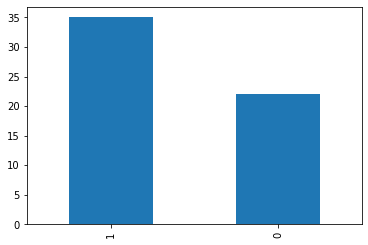

In [7]:
# Student needs to provide code similar to below
class_counts = y_test.value_counts()
ax = class_counts.plot(kind="bar")

### ========== Question 1.7 ==========
What would be the accuracy of the classifier, if all points were labelled as `1`? 

**Pro Tip** - You should always use a ['Dummy Model'](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators) (a ridiculously simple model) like this to compare with your 'real' models. It's very common for complex models to be outperformed by a simple model, such as predicting the most common class. When complex models are outperformed by 'Dummies', you should investigate why: often there was an issue with the code, the data, or the way the model works was misunderstood.

In [8]:
# Student needs to provide code similar to below
print('The baseline classifier (predict always 1) would achieve a classification accuracy score of: {:.3f}'.
      format(class_counts[1] / class_counts.values.sum()))


The baseline classifier (predict always 1) would achieve a classification accuracy score of: 0.614


### ========== Question 1.8 ==========
Now we want to explore the effect of the `k` parameter. To do this, train the classifier multiple times, each time setting the KNN option to a different value. Try `1`, `3`, `5`, `7`, `10`, `30`, `50`, `100`, and `200` and test the classifier on the test set. How does the k parameter effect the results?   
*Hint: Consider how well the classifier is generalising to previously unseen data, and how it compares to the dumb prediction accuracy.*   
*Hint: You should be able to implement this in a few lines using a for loop.*

In [9]:
# Student needs to provide code similar to below
k_list = [1, 3, 5, 7, 10, 30, 50, 100, 200]
ca = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    score = knn.score(X_test,y_test)
    ca.append(score)
    print('Performance on test with {} nearest neighbours: {:.3f}'.format(k, score))


Performance on test with 1 nearest neighbours: 0.860
Performance on test with 3 nearest neighbours: 0.877
Performance on test with 5 nearest neighbours: 0.895
Performance on test with 7 nearest neighbours: 0.912
Performance on test with 10 nearest neighbours: 0.912
Performance on test with 30 nearest neighbours: 0.947
Performance on test with 50 nearest neighbours: 0.930
Performance on test with 100 nearest neighbours: 0.895
Performance on test with 200 nearest neighbours: 0.860


***Student needs to answer similar to below:***

The model generalisation appears to improve as k increases, but only up to a point. As k becomes to large the output predictions are taking into account training examples that are potentially far away in feature space.  

### ========== Question 1.9 ==========
Plot the results (k-value on the x-axis and classification accuracy on the y-axis), making sure to label both axes. Can you conclude anything from observing the plot?

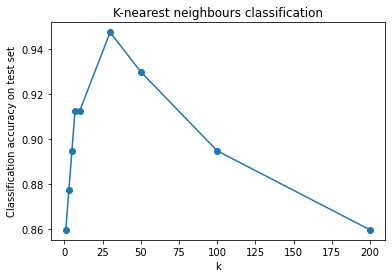

In [10]:
# Student needs to provide code similar to below
plt.scatter(k_list, ca)
plt.plot(k_list,ca, )
plt.xlabel('k')
plt.ylabel('Classification accuracy on test set')
plt.title('K-nearest neighbours classification')
plt.show()


***Student needs to answer similar to below:***

Increasing k improves performance up to a certain point. Beyond that point, the classifier uses virtually all training samples to classify a new instance and as a results classifies all instances to the dominant class (identically to our dumb baseline model).



### ========== Question 1.10 ==========
We now evaluate the classifier by looking at the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Familiar youself with the definition of confusion matrix in this link.

Scikit-learn has a [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix) implementation which returns a numpy array (square matrix) of dimensionality `C`, where `C` is the number of classes (2 in our case).

**a)** Select the best value for k from Questions 1.8 and 1.9 and compute the resulting confusion_matrix by using the builtin scikit-learn class and display the result.

In [11]:
# Student needs to provide code similar to below
knn = KNeighborsClassifier(n_neighbors=30).fit(X_train, y_train)
pred = knn.predict(X_test)
cm = confusion_matrix(y_test, pred)
cm


array([[20,  2],
       [ 1, 34]])

**e)** Normalise the produced confusion matrix by the true class and display the result.

In [12]:
# Student needs to provide code similar to below
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
cm_norm
## Confusion matrix has values c_ij such that true label i is predicted as label j, i.e. rows should sum to 1


array([[0.90909091, 0.09090909],
       [0.02857143, 0.97142857]])

**f)** By making use of the `plot_confusion_matrix` provided below, visualise the normalised confusion matrix. Plot the appropriate labels on both axes by making use of the `classes` input argument.

In [13]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

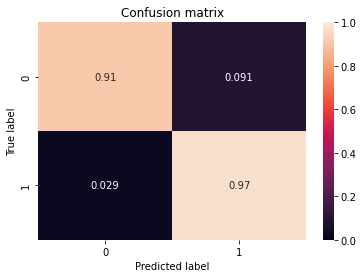

In [14]:
# Student needs to provide code similar to below
plt.figure()
plot_confusion_matrix(cm_norm, classes=knn.classes_)


### ========== Question 1.11 ==========
Read about the [cross entropy loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) (called `log_loss` here). It is a commonly used loss function (i.e. loss metric) used when we are trying to optimise binary classification models.

This metric takes as input the true labels and the estimated probability distributions. It makes sense to use this metric when we are interested not only in the predicted labels, but also in the confidence with which these labels are predicted.

For instance, think of the situation where you have a single test point and two classifiers. Both classifiers predict the label correctly, however classifier A predicts that the test point belongs to the class with probability 0.55, whereas classifier B predicts the correct class with probability 0.99. Classification accuracy would be the same for the two classifiers (why?) but the `log_loss` metric would indicate that classifier B should be favoured.

Produce a scatter plot, showing `log_loss` on your y axis. Use [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict_proba) to return probability estimates for the test data. Which value for `k` would you pick if `log_loss` was the error metric? Comment on why this might happen, and which metric would be a better evaluator of performance.

Performance on test with  1  nearest neighbours:  4.847547564197991
Performance on test with  3  nearest neighbours:  1.3509369277510692
Performance on test with  5  nearest neighbours:  1.341921449716757
Performance on test with  7  nearest neighbours:  1.3229292615923027
Performance on test with  10  nearest neighbours:  0.7405037252835884
Performance on test with  30  nearest neighbours:  0.7461861856978895
Performance on test with  50  nearest neighbours:  0.20284105592041254
Performance on test with  100  nearest neighbours:  0.24210740488847243
Performance on test with  200  nearest neighbours:  0.3215241261775338


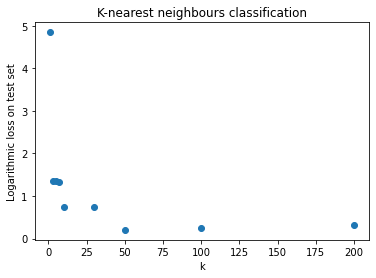

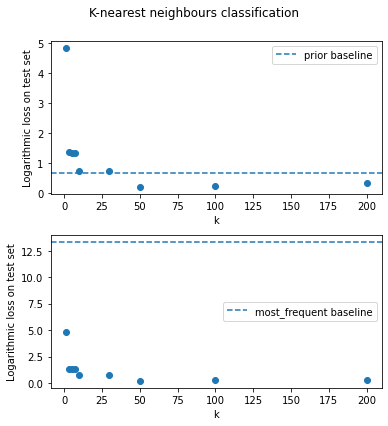

In [15]:
# Student needs to provide code similar to below
k_list = [1, 3, 5, 7, 10, 30, 50, 100, 200]
logloss = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    pred_proba = knn.predict_proba(X_test)
    this_logloss = log_loss(y_test, pred_proba)
    logloss.append(this_logloss)
    print('Performance on test with ', k, ' nearest neighbours: ', this_logloss)
plt.scatter(k_list, logloss)
plt.xlabel('k')
plt.ylabel('Logarithmic loss on test set')
plt.title('K-nearest neighbours classification')

# Extension - plot baselines too
baselines = ['prior', 'most_frequent']
fig, ax = plt.subplots(len(baselines), 1, figsize=(5.5,6))
from sklearn.dummy import DummyClassifier
bl_loss = {}
for ii, baseline in enumerate(baselines):
    plt.sca(ax[ii])
    dummy_classifier = DummyClassifier(strategy=baseline).fit(X_train, y_train)
    pred_proba = dummy_classifier.predict_proba(X_test)
    this_logloss = log_loss(y_test, pred_proba)
    plt.scatter(k_list, logloss)
    plt.axhline(this_logloss, label='{} baseline'.format(baseline), linestyle='--')
    plt.xlabel('k')
    plt.ylabel('Logarithmic loss on test set')
    plt.legend()

plt.suptitle('K-nearest neighbours classification')
plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.show()


***Student needs to answer similar to below:***

We would pick the 50-neighbours classifier as it has the lowest generalisation log loss. 

This is significantly different from the accuracy metric. One way to explain this is as follows. The 50-NN model, while it gets more instances wrong (lower accuracy), has a better judgement of its confidence in the prediction, whereas the 30-NN model gets more instances right (higher accuracy), but its judgement is way off (for example, in instances where it gets it wrong, it may predict the wrong label with high confidence, impacting the log loss).

However, the point where the knn model = dumb baseline is note indicated as clearly on this log loss graph. There are a couple of different dummy classifier baselines we could use for log loss:

1. Predict the dominant class with probability of 1 (sklearn.dummy.DummyClassifier(strategy='most_frequent').fit(X_train, y_train))
2. Predict probabilites respecting the class distribution from the training dataset (i.e. use prior probabilities) (sklearn.dummy.DummyClassifier(strategy='prior').fit(X_train, y_train))

I plotted these baselines on a second set of graphs with dotted lines. As you can see - predicting with 100% confidence comes at a very high cost (in terms of logarithmic loss)!



## 2. Decision Trees
One of the big advantages of decision trees is their interpretability. The rules learnt for classification are easy for a person to follow, unlike the opaque "black box" of many other methods, such as neural networks. We demonstrate the utility of this using the same dataset.

### ========== Question 2.1 ==========
Now we will train a Decision Tree classifier on the training data. Read about [Decision Tree classifiers](https://scikit-learn.org/stable/modules/tree.html) in `Scikit-learn` and how they are [used](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). 
Create a `DecisionTreeClassifier` instance, naming it `dt` and train it by using training data only (i.e. `X_train` and `y_tain`). Set the `criterion` attribute to `entropy` in order to measure the quality of splits using entropy. Use the default settings for the rest of the parameters.   

By default, trees are grown to full depth; this means that very fine splits are made involving very few data points. Not only does this make the trees hard to visualise (they'll be deep), but also we could be overfitting the data. For now, we arbitrarily choose a depth of 3 for our tree (to make it easier to interpret below), but this is a parameter we could tune. For consistency, use a `random_state=1000`.

In [16]:
# Student needs to provide code similar to below
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1000)
dt.fit(X_train.astype(float), y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1000)

We have mentioned in the class that decision trees have the advantage of being interpretable by humans. Now we visualise the decision tree we have just trained. Scikit-learn can export the tree in a `.dot` format. Run the following code:

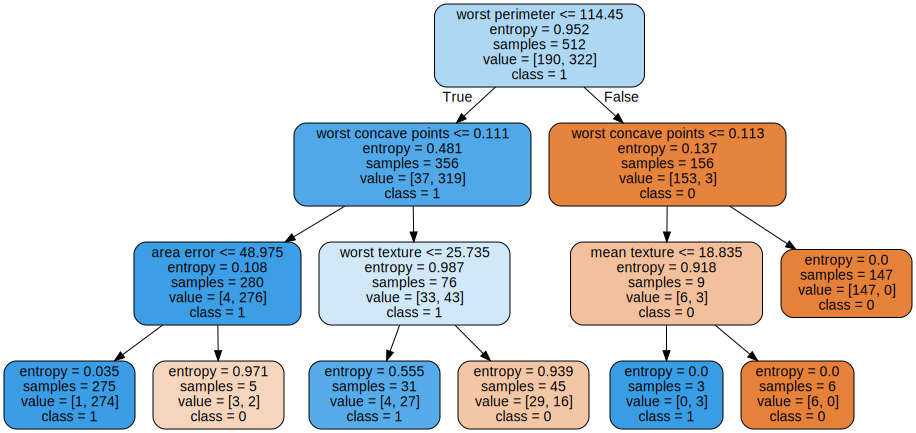

In [17]:
dot_data = export_graphviz(dt, out_file=None, 
    feature_names=X_train.columns,  
    class_names=['0', '1'],  
    filled=True, rounded=True,  
    special_characters=False)
graph = graphviz.Source(dot_data)
graph

An alternative way to visualise the tree is to open the output .dot file with an editor such as [this online .dot renderer](http://dreampuf.github.io/GraphvizOnline/). You can use the code below to create a dot-file and then copy and paste its contents into the online site (you can double click on the tree once it has been produced to view it in full screen).

In [18]:
column_names = X_train.columns
with open("tree.dot", 'w') as f:
    f = export_graphviz(dt, out_file=f,
                        feature_names=column_names,  
                        class_names=['0', '1'],  
                        filled=True, rounded=True,  
                        special_characters=False)

### ========== Question 2.2 ==========
Inspect the tree and describe what it shows. 

***Student needs to answer similar to below:***

We observe a tree with 5 internal nodes and 7 leaf nodes. We can see that the tree splits on the `worst perimeter` feature at the root node which indicates that it results in the largest information gain. Some, but not all of the leaves have an entropy of 0 (or close to 0) which indicates that the data at those nodes is from the same class.  


### ========== Question 2.3 ==========
Tree-based estimators (i.e. decision trees and random forests) can be used to compute feature importances. The importance of a feature is computed as the (normalized) total reduction of entropy (or other used `criterion`) brought by that feature. Find the relevant features of the classifier you just trained (i.e. those which are actually used in this short tree) and display feature importances along with their names.

In [19]:
# Student needs to provide code similar to below
for i, column in enumerate(column_names):
    if dt.feature_importances_[i] > 0:
        print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))


Importance of feature mean texture:, 0.020
Importance of feature area error:, 0.038
Importance of feature worst texture:, 0.038
Importance of feature worst perimeter:, 0.712
Importance of feature worst concave points:, 0.192


### ========== Question 2.4 ==========
Now we want to evaluate the performance of the classifier on unseen data. Use the trained model to predict the target variables for the test data set. Display the classification accuracy for both the training and test data sets. What do you observe? Are you surprised by the results?

In [20]:
# Student needs to provide code similar to below
prediction_train = dt.predict(X=X_train)
prediction_test = dt.predict(X=X_test)
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train,prediction_train)))
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test)))


Classification accuracy on training set: 0.955
Classification accuracy on test set: 0.930


***Student needs to answer similar to below:***

The decision tree classifier is (probably) not overfitting. The classification accuracy is similar for training and test. The decision tree has provided a very simple way to interpret the data - splitting it into 8 bins and applying a class to each bin. Clearly this is an oversimplification: even in the training data, the leaves of the tree contain many examples of the 'incorrect' class.

### ========== Question 2.5 ==========

Fit another `DecisionTreeClassifier` but this time grow it to full depth (i.e. remove the max_depth condition). Again, use a `random_state=1000`. Display the classification accuracy for training and test data as above. Again, what do you observe and are you surprised?

In [21]:
# Student needs to provide code similar to below
dt_fulldepth = DecisionTreeClassifier(criterion='entropy', random_state=1000)
dt_fulldepth.fit(X_train, y_train)
prediction_train2 = dt_fulldepth.predict(X=X_train)
prediction_test2 = dt_fulldepth.predict(X=X_test)
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train,prediction_train2)))
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test2)))


Classification accuracy on training set: 1.000
Classification accuracy on test set: 0.912


***Student needs to answer similar to below:***

This is a classic case of overfitting. The tree is allowed to grow to full depth and perfectly fit the training data. The result is that the test accuracy is much lower than the train; in fact it is only slightly more accurate than the very simple depth 3 tree! It's important to note that, when grown to full depth, decision tree classifiers can perfectly separate the training data (if no two datapoints are identical but have different classes). Performance on unseen data is likely to be much lower however.


### ========== Question 2.6 ==========
By using seaborn's heatmap function, plot the normalised confusion matrices for both the training and test data sets **for the max_depth=3 decision tree from question 2.1**. Make sure you label axes appropriately.   
*Hint: You can make use of the `plot_confusion_matrix` function below.*  

In [22]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

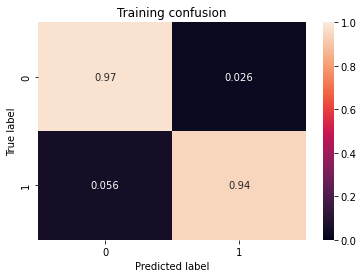

In [23]:
# Normalised Data

# Student needs to provide code similar to below
cm = confusion_matrix(y_train, prediction_train)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')


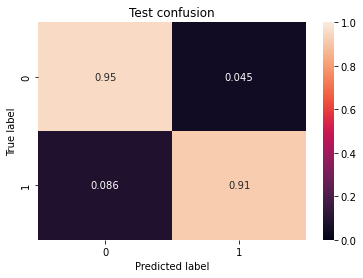

In [24]:
# Validation Data

# Student needs to provide code similar to below
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Test confusion')


**N.B. it will be obvious if you have plotted the full depth decision tree as the training confusion matrix will be the identity**

### ========== Question 2.7 ==========

Finally we will create a [`Random decision forest`](http://scikit-learn.org/0.24/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier and compare the performance of this classifier to that of the decision tree. The random decision forest is an ensemble classifier that consists of many decision trees and outputs the class that is the mode of the class's output by individual trees. Start with `n_estimators = 100`, use the `entropy` criterion and the same train/test split as before. Plot the classification accuracy of the random forest model on the test set and show the confusion matrix. How does the random decision forest compare performance wise to the decision tree?

Classification accuracy on test set: 0.965


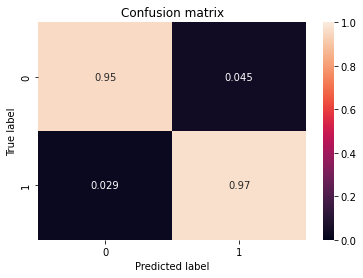

In [25]:
# Student needs to provide code similar to below
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test)))
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)


### ========== Question 2.8 ==========
How high can you get the performance of the classifier by changing the max depth of the trees (`max_depth`), or the `max_features` parameters? Try a few values just to get a look. *Don't do a grid search or anything in-depth, just get a feel*. Try the same settings twice...do you get the same accuracy?

Classification accuracy on test set with max features = 1 and max_depth = None: 0.930
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.930
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.912
Classification accuracy on test set with max features = 1 and max_depth = 10: 0.947
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.965
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.930
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.947
Classification accuracy on test set with max features = sqrt and max_depth = 10: 0.965
Classification accuracy on test set with max features = log2 and max_depth = None: 0.947
Classification accuracy on test set with max features = log2 and max_depth = 2: 0.947
Classification accuracy on test set with max features = log2 and max_depth = 5: 0.947
Classification accuracy on test set with max features =

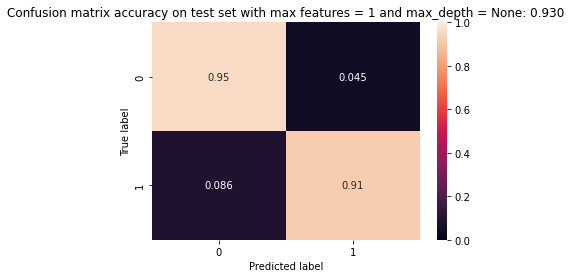

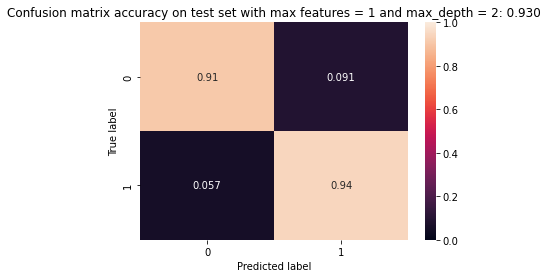

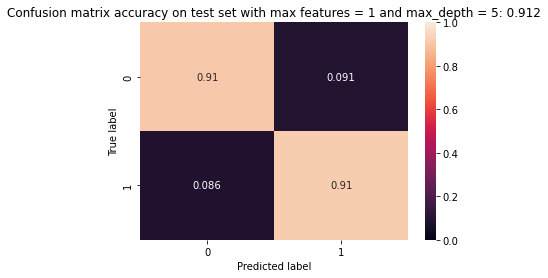

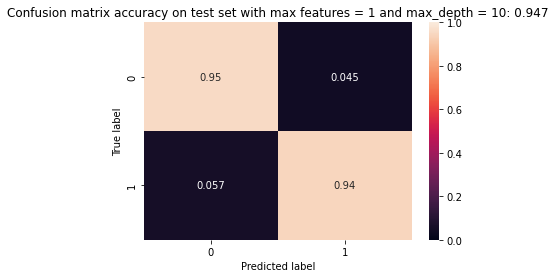

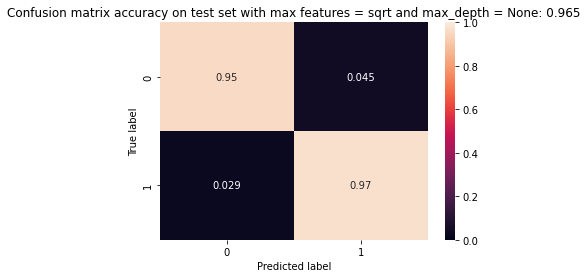

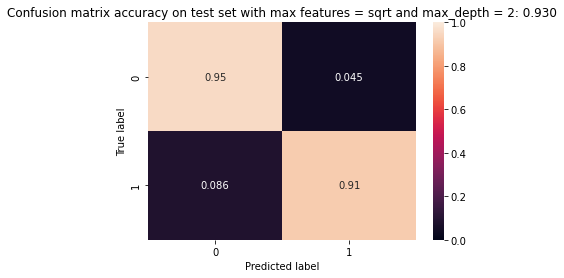

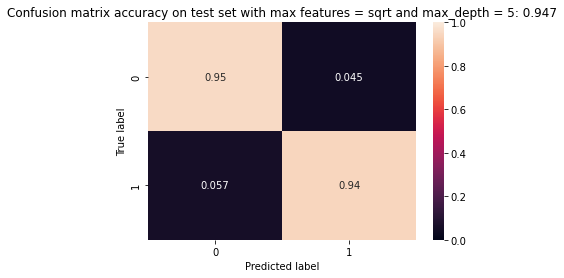

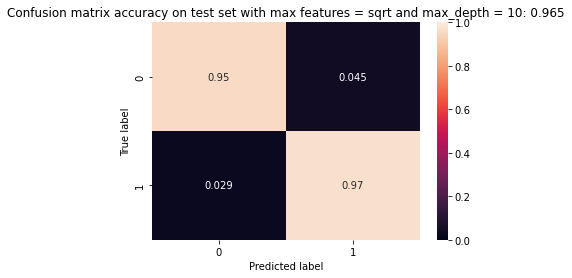

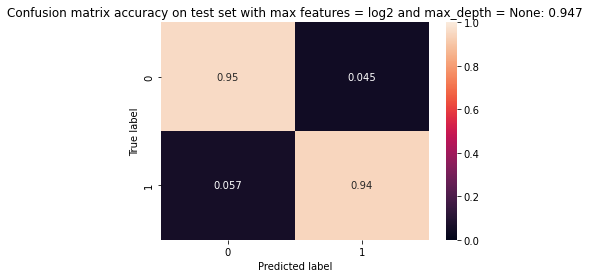

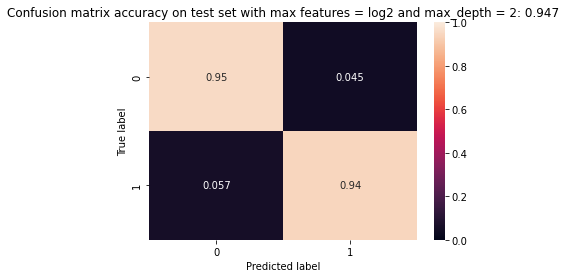

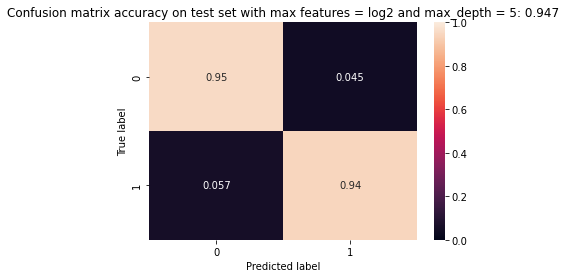

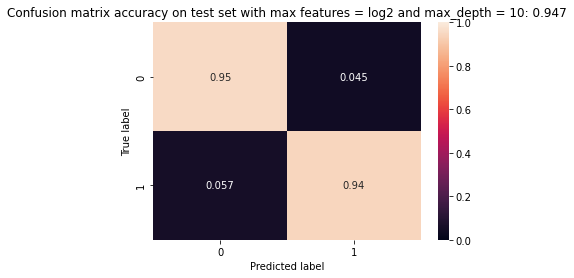

In [26]:
# Student needs to provide code similar to below
from itertools import product
n_estimators = 500
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 5, 10]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_, title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))


N.B. Observing these confusion matrices you'll see something very important - for some configurations, the Random Forest **always predicts the majority class**: incidentally these are also the cases which do the best. This highlights (again) the importance of always checking performance against a dummy classifier!!!

Additionally, if you want to reproduce your results, you must set the random seed (you can do this with the `random_state` argument). Random forests are...random!

### ========== Question 2.9 ==========
Compare the feature importances as estimated with the decision tree and random forest classifiers.

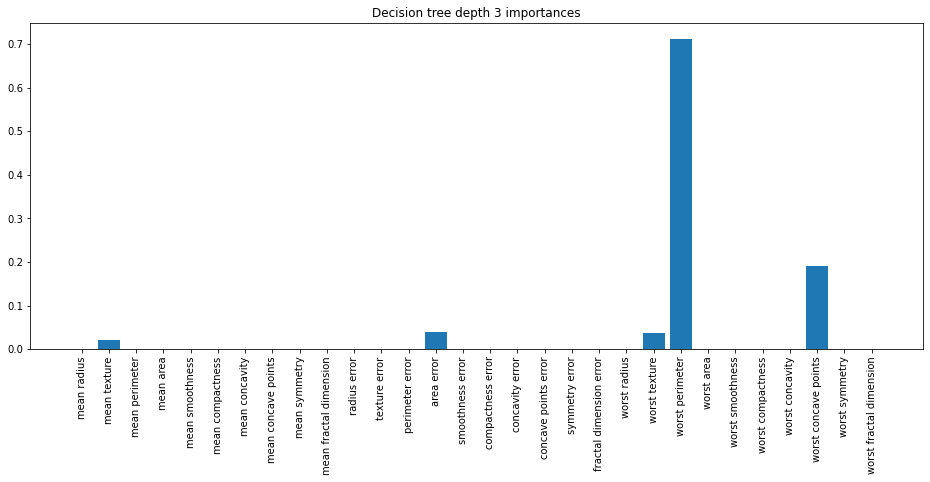

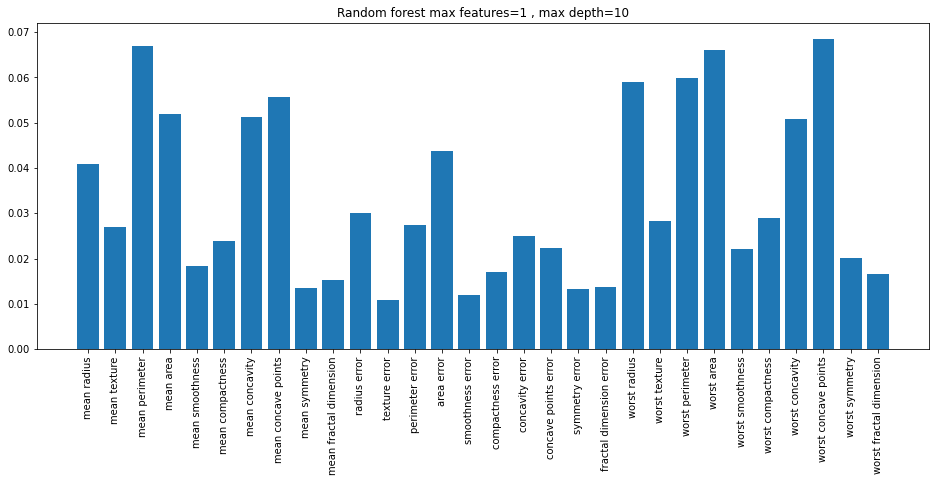

Importance of feature mean radius, DT: 0.000, RF: 0.041
Importance of feature mean texture, DT: 0.020, RF: 0.027
Importance of feature mean perimeter, DT: 0.000, RF: 0.067
Importance of feature mean area, DT: 0.000, RF: 0.052
Importance of feature mean smoothness, DT: 0.000, RF: 0.018
Importance of feature mean compactness, DT: 0.000, RF: 0.024
Importance of feature mean concavity, DT: 0.000, RF: 0.051
Importance of feature mean concave points, DT: 0.000, RF: 0.056
Importance of feature mean symmetry, DT: 0.000, RF: 0.014
Importance of feature mean fractal dimension, DT: 0.000, RF: 0.015
Importance of feature radius error, DT: 0.000, RF: 0.030
Importance of feature texture error, DT: 0.000, RF: 0.011
Importance of feature perimeter error, DT: 0.000, RF: 0.027
Importance of feature area error, DT: 0.038, RF: 0.044
Importance of feature smoothness error, DT: 0.000, RF: 0.012
Importance of feature compactness error, DT: 0.000, RF: 0.017
Importance of feature concavity error, DT: 0.000, RF

In [27]:
# Student needs to provide code similar to below
rf = RandomForestClassifier(n_estimators=500, 
                            criterion='entropy', 
                            max_features=1, 
                            max_depth=10, 
                            n_jobs=2)
rf.fit(X_train, y_train)
_, ax1 = plt.subplots(1, 1, figsize=(16,6))
xx = np.arange(len(dt.feature_importances_))
ax1.bar(xx, dt.feature_importances_)
ax1.set_xticks(xx)
ax1.set_xticklabels(column_names, rotation='vertical')
ax1.set_title('Decision tree depth 3 importances')
plt.show()

_, ax2 = plt.subplots(1, 1, figsize=(16,6))
ax2.bar(xx, rf.feature_importances_)
ax2.set_xticks(xx)
ax2.set_xticklabels(column_names, rotation='vertical')
ax2.set_title('Random forest max features=1 , max depth=10')
plt.show()

for i, column in enumerate(column_names):
    if dt.feature_importances_[i] > 0 or rf.feature_importances_[i]:
        print('Importance of feature {}, DT: {:.3f}, RF: {:.3f}'.format(column, dt.feature_importances_[i], rf.feature_importances_[i]))
